# Variational optimization of Rabi

In [1]:
# front matter
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
import scipy.linalg as la
import pickle

# If your screen has retina display this will increase resolution of plots
%config InlineBackend.figure_format = 'retina' 

with open("psi.pickle", "rb") as f0:
    psi = pickle.load(f0)
with open("E.pickle", "rb") as f1:
    E = pickle.load(f1)

In [2]:
# Basic constants and parameters
# grid points
N=2000

# spatial grid
XMin=-50
XMax=50
X=np.linspace(XMin, XMax, N)
X2=np.linspace(XMin, XMax, 2*N)

# momentum grid
P=(2*np.pi/(XMax-XMin))*np.concatenate((np.arange(0,N//2), np.arange(-N//2,0)))

# initial and final conditions
w0=0.35
w1=1
dt=0.25

#define pauli matrixes
S0 = np.array([[1, 0], [0, 1]])
S1 = np.array([[0, 1], [1, 0]])
S3 = np.array([[1, 0], [0, -1]])

## Function Defination

In [3]:
def simulation(a,b,v,tau,wp):
    M = int(tau/dt)
    psi_0 = psi[0,a,b][v]
    psi_1 = np.zeros(2*N, dtype=np.complex128)
    psi_2 = np.zeros(2*N, dtype=np.complex128)
    psi_3 = np.zeros(2*N, dtype=np.complex128)

    UT = np.exp(-1j*(P**2/2)*dt/2)

    for m in range(M+1):
        # momentum 1/2 update
        # saperate spin up and down
        psi_0_up = psi_0[::2]    
        phi_0_up = np.fft.fft(psi_0_up) 
        phi_1_up = UT*phi_0_up
        psi_1_up = np.fft.ifft(phi_1_up)

        psi_0_down=psi_0[1::2]
        phi_0_down = np.fft.fft(psi_0_down)
        phi_1_down= UT*phi_0_down
        psi_1_down=np.fft.ifft(phi_1_down)

        psi_1[::2] = psi_1_up
        psi_1[1::2] = psi_1_down

        Vcase = np.einsum('i,jk->ijk', (wp[m]*X)**2/2, S0) + np.einsum('i,jk->ijk', a*X, S1) + b*S3
        UV = la.expm(-1j*Vcase*0.25)
        psi_2 = np.einsum('ijk,ik->ij', UV, psi_1.reshape(-1, 2))
        psi_2 = psi_2.reshape(-1)
        
        # momentum 1/2 update
        # saperate spin up and down
        psi_2_up = psi_2[::2]    
        phi_2_up = np.fft.fft(psi_2_up) 
        phi_3_up = UT*phi_2_up
        psi_3_up = np.fft.ifft(phi_3_up)

        psi_2_down=psi_2[1::2]
        phi_2_down = np.fft.fft(psi_2_down)
        phi_3_down= UT*phi_2_down
        psi_3_down=np.fft.ifft(phi_3_down)

        # combine up and down
        psi_3[::2] = psi_3_up
        psi_3[1::2] = psi_3_down

        psi_0 = psi_3
    return psi_0

In [4]:
# Partition function
def Z(w,a,b,n,beta):
    Z_0=0
    for v in range(n):
        energy = E[w, a, b][v]
        Z_0 += np.exp(-beta * energy)  
    return Z_0

# Helmholtz free energy difference
def delta_F(a,b,n,beta):
    delta_F_0=1/beta*np.log(Z(0,a,b,n,beta)/Z(1,a,b,n,beta))
    return delta_F_0

In [5]:
def var(a,b,n,tau,beta,wp):
    Fm=0.0
    Sm=0.0
    Z0= Z(0,a,b,n,beta)
    DF= delta_F(a,b,n,beta)
    for i in range(n):
        for j in range(n):
            psi_t=simulation(a,b,i,tau,wp)
            psi1=psi[1,a,b][j]
            abs_dot=np.abs(np.dot(psi1,psi_t))**2
            Fm+=np.exp(-beta*E[1,a,b][j])*abs_dot/Z0
            Sm+=np.exp(-beta*(2*E[1,a,b][j]-E[0,a,b][i]))*abs_dot/Z0
    Var=Sm-Fm**2
    Var_dis=Var/np.exp(-2*beta*DF)
    return Var_dis

## N-dimensional polynomial work protocal
$\omega(t) = \omega_0 + a_1 t + a_2 t^2 + \cdots + a_{k-1} t^{k-1} + a_k t^k$

In [6]:
# N-dimensional polynomial work protocal
# power_t vector (t_j^0, t_j^1, ..., t_j^(n-1))
def power_vector(k,tau):
    M=int(tau/dt)
    t_list = np.linspace(0, tau, M+1)
    return np.array([[t_list[j]**i for i in range(k)] for j in range(M+1)])

# work protocal
def wp_poly(a_list,tau):
    M=int(tau/dt)
    n = len(a_list)+2

    q=np.sum(power_vector(n-2,tau)[M]*a_list)
    a1=(w1-w0)/tau-q*tau

    a_list = np.append([w0, a1],a_list)
    p = [np.sum(power_vector(n,tau)[i]*a_list) for i in range(M+1)]
    
    return p

## Constrained optimization

In [7]:
a = 0.75
b = 0.75
n =10
tau = 5
beta = 6

a_list_length = 5 # a_list的长度

# 定义目标函数
def func(a_list):
    return var(a, b, n, tau, beta, wp_poly(a_list, tau))

# 定义约束条件
def constraint(a_list):
    result = wp_poly(a_list, tau)
    return result
cons = ({'type': 'ineq', 'fun': constraint})

# 执行优化
def perform_optimization(guess):
    poly_optimization = minimize(func, guess, method='COBYLA', constraints=cons)
    # poly_optimization = minimize(func, guess, method='SLSQP', constraints=cons)
    # poly_optimization = minimize(func, guess, method='trust-constr', constraints=cons)
    # poly_optimization = minimize(func, guess, method='TNC', constraints=cons)

    return poly_optimization

In [8]:
initial_guess = np.random.rand(a_list_length)
res = perform_optimization(initial_guess)

# 输出结果
if res.success:
    print("优化成功")
    print("最优参数值：", res.x)
    print("最优做功路径：", wp_poly(res.x, tau))
    print("最小化的目标函数值：", res.fun)
else:
    print("优化失败")
    print(res.message)

优化成功
最优参数值： [ 0.04627354  0.3720403   0.56261175  0.42067409 -0.1120457 ]
最优做功路径： [0.35, 2.2344502902368246, 4.200959812465307, 6.410375152653779, 9.132209582805881, 12.744701973796904, 17.715180175538734, 24.560728864473454, 33.789161858395516, 45.820298898602594, 60.88754689937498, 78.91978566478362, 99.40355807282688, 121.22556472689573, 142.49546307456768, 160.34897099372944, 170.7312748460277, 168.16074199764955, 145.47293780742984, 93.54494708228958, 1.0]
最小化的目标函数值： 4.764999225969559


a= 0.75
b= 0.75
n= 10
tau= 5
beta= 6


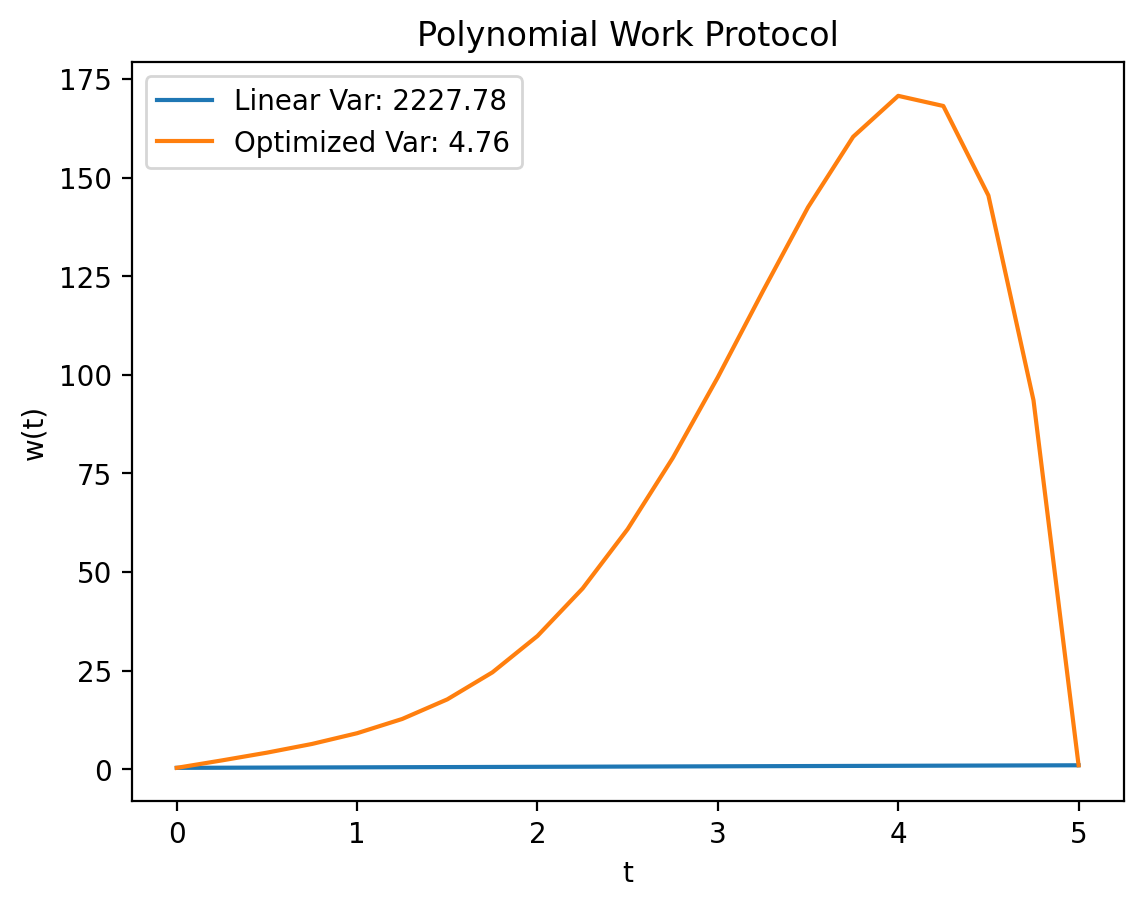

In [11]:
print("a=", a)
print("b=", b)
print("n=", n)
print("tau=", tau)
print("beta=", beta)


M=int(tau/dt)
t_list = np.linspace(0, tau, M+1)


# Visualization
# x-axis
Poly_x_Var = t_list[M//2]

# initial work protocol guess
linear_list=np.array(np.zeros(20))
plt.plot(t_list, wp_poly(linear_list,tau), label=f'Linear Var: {var(a,b,n,tau,beta,wp_poly(linear_list,tau)):.2f}')
poly_y_Var_initial = wp_poly(linear_list,tau)[M//2]


# optimized work protocol
plt.plot(t_list, wp_poly(res.x,tau),label=f'Optimized Var: {var(a,b,n,tau,beta,wp_poly(res.x,tau)):.2f}')
poly_y_Var_optimized = wp_poly(res.x,tau)[M//2]



plt.xlabel("t")
plt.ylabel("w(t)")
plt.title("Polynomial Work Protocol")
plt.legend()
plt.show()


